In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code"></form>''')

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model

<p> Toggle code to view final data cleaning steps </p>

<h1> Exploring the Value of Quarterbacks on Rookie Contracts </h1>
<p style = "font-size:110%"> Quarterback is <i>the</i> position in football. Hopes of a franchise rest on the shoulders of whoever lines up under center. Quarterbacks get the credit, the glory, the money when a team succeeds. They are the first ones to fall when a team underachieves, falters, or collapses under pressure. Given the significance of the quarterback, it is no surprise they are among the highest paid players in the game. Even an above average quarterback can command $25 million per year contracts. With quarterbacks signing record breaking contracts every year, NFL teams began wondering: ‘How can we get valuable quarterbacks at a discounted rate?’. The answer: talented quarterbacks playing on rookie deals. </p>

<h2> A New Era in Quarterback Evaluation </h2>
<p style = "font-size:110%" > It wasn’t always this way. Before the advent of a contract-scale, some of the highest-paid players on teams were unproven rookies (JaMarcus Russell, anyone?)  Now, rookie contracts are controlled. This is especially valuable for the quarterback position, where talented rookies would fetch far more on the open market. Teams are taking advantage by filling out the rest of the roster around their talented, cost-controlled young quarterback. Patrick Mahoomes, still on his rookie contract, won the Superbowl in the 2019-2020 season a year after winning MVP. Lamar Jackson, the reigning MVP, is also on rookie contract. Common knowledge knows teams are getting a great deal; the question is, just how great a deal are they getting? </p>

<p style = "font-size:110%"> To answer that, we will be using a Linear Regression to build a model that predicts salary. Using quarterback passing statistics pulled from pro-football-reference.com, the model will be built using statistics that correlate most with a quarterbacks average salary*. The model will be trained on ‘veteran’ quarterbacks. The term ‘veteran’ will mean any quarterback who has already signed and is receiving any contract that isn’t their rookie deal. We will be using the statistics from a quarterbacks “contract year”, or the statistics from the year before they signed their contract. Some quarterbacks fall off after signing their big deal, so contract year statistics are used to fully capture the performance that led to the team to offer what they did. To eliminate career back-ups who are paid for insurance and see little game time, only quarterbacks who threw at least 100 passes in 2018 or 2019 were considered. </p>

<p style = "font-size: 90%">*Average salary on a contract is a misleading number, as it implies money owed to the player is evenly distributed across the length of the contract. This is not typically the case, as teams commonly ‘back load’ contracts, or pay out more of the contract in later years. Teams may also offer more guaranteed money to woo star players, offering more up front. Despite average salary not perfectly reflecting what a player receives annually, it still makes sense as a numerical value to assign to a players worth. Salary data was scraped from <a href = https://www.spotrac.com/> spotrac.com</p>

In [45]:
# Read in DataFrame of contract year stats. 
QBs_DF = pd.read_csv(r'qb_contract_year_stats_df.csv', index_col='Year')

# For model purposes, only consider QBs who threw >100 passes in contract year. 
QBs_DF = QBs_DF[QBs_DF['Att'] >= 100]


# Correct naming convention on 'Pos' column
QBs_DF['Pos'] =['QB' for x in range(len(QBs_DF['Pos']))]

# Check which rows have NaN
QBs_DF.isna().sum()

# Fill NaN columns with known NaN values. Fourth quarter comebacks and Game-winning drives that are NaN are zero. 
QBs_DF['4QC'] = QBs_DF['4QC'].fillna(0.0)
QBs_DF['QBrec'] = QBs_DF['QBrec'].fillna('0-0-0')
QBs_DF['GWD'] = QBs_DF['GWD'].fillna(0.0)

# Separate 'Wins', 'Losses', and 'Ties' into their own categories

def wins_losses(row):
    row['Wins'] = int(row['QBrec'].split('-')[0])
    row['Losses'] = int(row['QBrec'].split('-')[1])
    row['Ties'] = int(row['QBrec'].split('-')[2])
    return row
QBs_DF = QBs_DF.apply(wins_losses, axis = 1)

In [46]:
# Building out model, using correlation as selection criteria. Ignoring QBS, AV, any stats that are built out using other stats. 
# QBR incorparates TD, Yds, etc. 
print(QBs_DF.corr()['Salary'].sort_values(ascending = False)[1:])

QBR       0.798201
AV        0.712687
TD        0.706057
ANY/A     0.700755
Wins      0.698456
Rate      0.668777
AY/A      0.653981
Yds       0.630014
1D        0.618144
Y/G       0.610019
GS        0.607986
Cmp       0.606086
NY/A      0.578591
TD%       0.575759
Att       0.565157
G         0.564411
Y/A       0.538598
GWD       0.521994
Cmp%      0.480735
Lng       0.478551
4QC       0.466918
Y/C       0.397730
Sk        0.330533
Yds.1     0.281739
Int       0.202116
Ties      0.167312
Age       0.142439
No.       0.118253
Losses    0.089561
Sk%      -0.319938
Int%     -0.408356
Name: Salary, dtype: float64


<p style = "font-size:110%"> Model variables were selected based on how highly they correlated with salary. Above is the list of possible variables and how they correlate with salary. Despite a high correlation, statistics such as ‘QBR’, ‘AV’, ‘Rate’ were ignored as they are variables that are aggregations of many quarterback passing statistics. Variables ‘TD’, ‘1D’, ‘ANY/A’ (average net yards per pass attempt), ‘Cmp%’, and ‘Int%’ were used instead. ‘Wins’ was not used as this is a team statistic. Objective was to isolate individual quarterback statistics as much as possible.</p>

In [47]:
# Selected TDs, ANY/A, 1Ds, CMPS%, and INT%. Five variables, now checking for colinearity. Selected variables that, despite not being the most correlated with Salary, 
# on surface prevent colinearity issues and isolate away team factors (Wins, for example, can be seen as team factor). 
QBs_DF.corr()['TD'].sort_values(ascending = False)[1:]
# TDs highly correlated with 1Ds. Dropping 1Ds. 
corr = QBs_DF[['TD', 'ANY/A','1D','Cmp%','Int%']].corr()
corr.style.background_gradient(cmap='copper').set_precision(2)

,TD,ANY/A,1D,Cmp%,Int%
TD,1,0.69,0.91,0.38,-0.28
ANY/A,0.69,1,0.57,0.73,-0.35
1D,0.91,0.57,1,0.29,-0.21
Cmp%,0.38,0.73,0.29,1,-0.49
Int%,-0.28,-0.35,-0.21,-0.49,1


<p style = "font-size:110%"> Above is the colinearity table with the five model variables. Notice '1D' is highly correlated (.91) with TD. Therefore, '1D' is dropped from the model </p>

In [48]:
# Similar correlation problems exist for Cmp% (completion percentage). Running a linear regression with 'TD', 'ANY/A', 'Cmp%', and 'Int%' 
# led to a negative coeffecient for 'Cmp%'. Logically, a more accurate quarterback would not be paid less. Thus, 'Cmp%' was eliminated
model_variables = ['TD', 'ANY/A', 'Cmp%', 'Int%']
outcome_variable = ['Salary']
train_x = QBs_DF[model_variables]
train_y = QBs_DF[outcome_variable]

In [49]:
reg_model = linear_model.LinearRegression()
fit_model = reg_model.fit(train_x, train_y)
fit_model.coef_
pd.Series(fit_model.coef_[0], index = model_variables, name= 'Regression Model Variable Coefficients').apply(lambda x: round(x,2))

TD        470052.01
ANY/A    3414694.41
Cmp%     -129783.76
Int%    -2101573.24
Name: Regression Model Variable Coefficients, dtype: float64

<p style="font-size:110%"> Using the LinearRegression class from the sklearn linear_model module, we calculated a regression model for our model variables. This revealed an issue with the completion percentage variable. The ‘Cmp%’ has a negative coefficient, implying that the more accurate a quarterback is the more they will be paid. This does not make logical sense, and such was removed from the final model. </p>

In [50]:
model_variables = ['TD','ANY/A', 'Int%']
outcome_variable = ['Salary']
train_x = QBs_DF[model_variables] # Variables for use on the model
train_y = QBs_DF[outcome_variable] # Salary. Outcome variable for model. 

In [51]:
reg_model = linear_model.LinearRegression()
fit_model = reg_model.fit(train_x,train_y)
pd.Series(fit_model.coef_[0], index = model_variables, name = 'Final Regression Model Variable Coefficients').apply(lambda x: round(x,2))

TD        484013.42
ANY/A    3088083.27
Int%    -1956263.76
Name: Final Regression Model Variable Coefficients, dtype: float64

<p style="font-size:110%"> With our model constructed, we can finally investigate the value of rookie quarterbacks. Using passing statistics from each quarterback's most recent year, we measure how much they <i>would </i>be paid on the open market vs how much they <i>are</i> being paid. </p>

In [52]:
## Load in rookie data set. Rookie data set will be the test data. Compare to actual salary to observe how much overpaid/underpaid rookies are. 
rookie_df = pd.read_csv('rookie_contracts_2019_stats.csv')
rookie_df = rookie_df.apply(wins_losses, axis = 1)

test_x = rookie_df[model_variables]
test_y = rookie_df[outcome_variable]

predict_y = reg_model.predict(test_x)
predict_y = np.concatenate([y if y > 0 else y -y for y in predict_y])

In [53]:
# Diff between predicted and actual
errors_y = predict_y - test_y.values
# Constructing Axis for plot
x_axis = rookie_df['Player'].apply(lambda x: x.split()[0] + '\n' + x.split()[1])
y_axis = test_y.values
y_axis_2 = predict_y

In [54]:
# Helper functions for cunstructing presentable graph

def create_error_arrow(index):
    # Draws arrows between 'Predicted' and 'Actual'. If there is not enough space between actual and predicted markers, function places difference above markers.
    error = y_axis_2[index] - y_axis[index]
    if error < 0:
        ax.annotate("",xy=(x_axis[index], y_axis_2[index]), xytext=(x_axis[index], ((y_axis_2[index] + y_axis[index])/2) - 1000000),arrowprops=dict(arrowstyle="->", color = 'red'))
        ax.annotate("", xy=(x_axis[index], y_axis[index]), xytext = (x_axis[index],((y_axis_2[index] + y_axis[index])/2) + 1000000), arrowprops = dict(arrowstyle = '->', color = 'red'))
        ax.annotate(format_errors(y_axis_2[index] - y_axis[index]), xy=(x_axis[index], ((y_axis_2[index] + y_axis[index])/2)), xytext=(-25, 0), textcoords = 'offset points', color = 'red')
    elif abs(error)  < 4000000:
        ax.annotate("", xy = (x_axis[index], y_axis_2[index]), xytext = (x_axis[index], y_axis[index]), arrowprops= dict(arrowstyle='->', color = 'green'))
        ax.annotate(format_errors(error), xy = (x_axis[index], y_axis_2[index]), xytext = (-20, 15), textcoords = 'offset points', color = 'green')
    else:
        ax.annotate("",xy=(x_axis[index], y_axis_2[index]), xytext=(x_axis[index], ((y_axis_2[index] + y_axis[index])/2) + 1000000),arrowprops=dict(arrowstyle="->", color = 'green'))
        ax.annotate("", xy=(x_axis[index], y_axis[index]), xytext = (x_axis[index],((y_axis_2[index] + y_axis[index])/2) - 1000000), arrowprops = dict(arrowstyle = '->', color = 'green'))
        ax.annotate(format_errors(y_axis_2[index] - y_axis[index]), xy=(x_axis[index], ((y_axis_2[index] + y_axis[index])/2)), xytext=(-25, 0), textcoords = 'offset points', color = 'green')
def format_errors(error):
    #Format erors to condense and fit on graph.
    error = roundup(int(error))
    if abs(error) < 1000000:
        error_form = '${:,}'.format(error)
        error_form = error_form.replace(',000','')
        return error_form + ' K'
    else:
        error_form = '${:,}'.format(error)
        error_form = error_form.replace('00,000','').replace(',','.')
        return error_form + ' M'    
    
def roundup(number):
    # Round numbers to nearest hundred thousand
    number = number / 100000
    number = round(number)
    number = number * 100000
    return int(number)
    

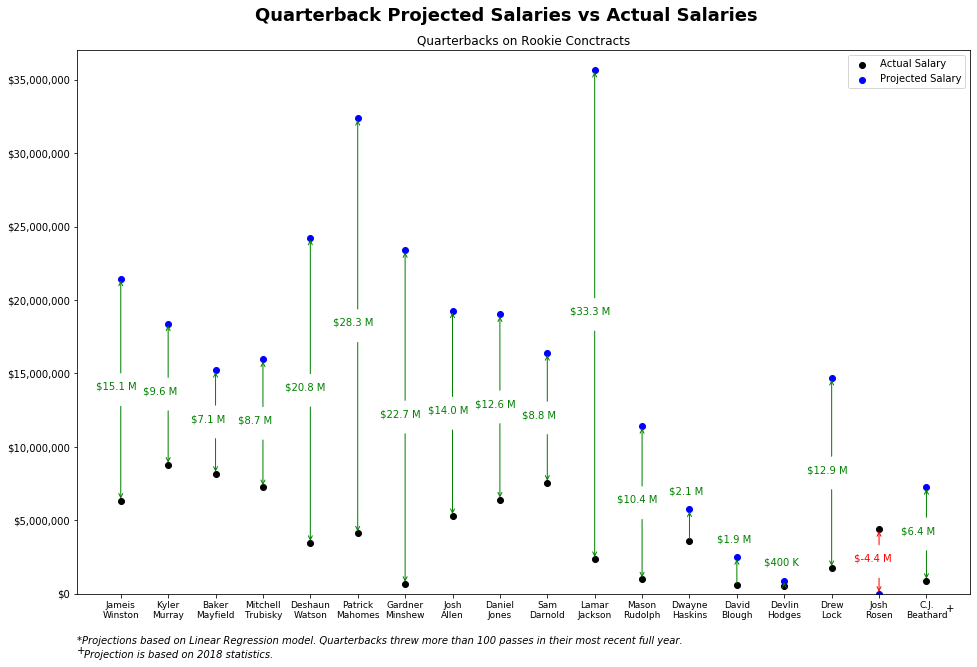

In [55]:
fig, ax = plt.subplots()
fig.set_size_inches(16,10)
ax.scatter(x_axis, y_axis, marker = 'o', label = 'Actual Salary', color = 'black')
ax.scatter(x_axis, y_axis_2, label = 'Projected Salary', color = 'blue')
for i in range(len(x_axis)):
    create_error_arrow(i)
ax.legend()
ax.set_ylim(0,37000000)
ax.set_yticklabels(['${:,}'.format(x) for x in range(0,35000001, 5000000)])
ax.set_xticklabels(x_axis, fontsize = 9)
fig.suptitle('Quarterback Projected Salaries vs Actual Salaries ', size = 18, fontweight = 'bold', y = .94)
ax.set_title('Quarterbacks on Rookie Conctracts')
ax.annotate('*Projections based on Linear Regression model. Quarterbacks threw more than 100 passes in their most recent full year.', xy = (0, -50), xycoords = 'axes points', fontstyle = 'italic')
ax.annotate('+', xy = (x_axis[17], 0), xytext = (20, -18), textcoords = 'offset points')
ax.annotate('+', xy = (0, -60), xycoords = 'axes points', fontstyle = 'italic')
ax.annotate('Projection is based on 2018 statistics.', xy = (7, -64), xycoords = 'axes points', fontstyle = 'italic')
plt.show()

<h2> Conclusion </h2>

<p style = 'font-size:110%' > Our results reveal what we already know: quarterbacks on rookie contracts are a boon for franchises. As one might expect, the past two MVPs (Patrick Mahomes and Lamar Jackson) lead the way in terms of most underpaid. Gardner Minshew, whose journey from sixth-round pick to future of the Jacksonville Jaguars, underscores the value of a quarterback on a cheap contract. Minshew will be paid $675,000 in 2020, but performs at a level comparable to a quarterback making 20x as much. Minshew was one of the league's best stories, but even quarterbacks who face media criticism can be seen as bargains. The Cleveland Browns were a disappointment to many, with quarterback Baker Mayfield taking the brunt of the criticism. He still performed at a level above his pay grade. </p>

<p style = 'font-size:110%'>
This analysis has its flaws. Only three variables are used in our model, and model selection was based more on feel than a backward or forward selection process. However, the results are in line with our expectations on the value of rookie contracts. Much has been made in the press about building around quarterbacks on rookie deals, and maybe the value of the contract is even greater than the hype. 
</p>